In [1]:
%load_ext autoreload
%autoreload 2

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
from PIL import Image, ImageOps
import requests
import torch
import matplotlib.pyplot as plt
import numpy as np

import torch
import requests
from tqdm import tqdm
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline, DiffusionPipeline
import torchvision.transforms as T

from utils import preprocess, prepare_mask_and_masked_image, recover_image

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
to_pil = T.ToPILImage()

### First lets instantiate an inpainting stable diffusion model

In [4]:
# make sure you're logged in with `huggingface-cli login` - check https://github.com/huggingface/diffusers for more details

'''pipe_inpaint = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    revision="fp16",
    torch_dtype=torch.float16,
)
pipe_inpaint = pipe_inpaint.to("cuda")
'''

pipe_inpaint = DiffusionPipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5",  torch_dtype=torch.float16)
pipe_inpaint.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "stable-diffusion-v1-5/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

### The image to fake

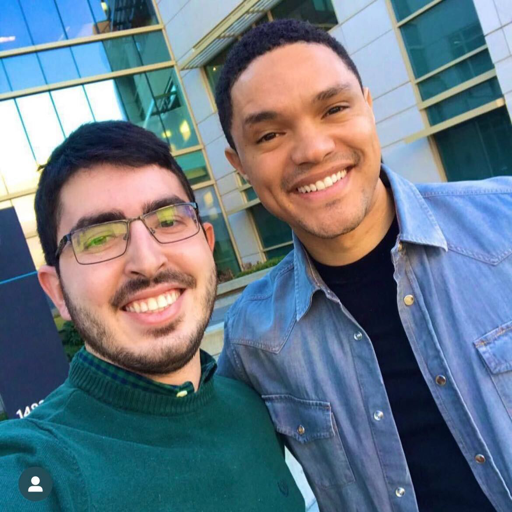

In [5]:
init_image = Image.open(f'../assets/trevor_5.jpg').convert('RGB').resize((512,512))
mask_image = Image.open(f'../assets/trevor_5.tif').convert('RGB')
mask_image = ImageOps.invert(mask_image).resize((512,512))

init_image

### Running Stable Diffusion Inpainting

In [6]:
# prompt = "man riding a motorcycle at night"
# prompt = "two men in a wedding"
# prompt = "two men in a restaurant hugging"
# prompt = "two men in a classroom"
# prompt = "two men in a library"
prompt = "two men in the plane hugging"


# A good seed
SEED = 9209

# Uncomment the below to generated other images
# SEED = np.random.randint(low=0, high=100000)

torch.manual_seed(SEED)
print(SEED)

strength = 0.7
guidance_scale = 7.5
num_inference_steps = 100

image_nat = pipe_inpaint(prompt=prompt, 
                     image=init_image, 
                     mask_image=mask_image, 
                     eta=1,
                     num_inference_steps=num_inference_steps,
                     guidance_scale=guidance_scale,
                     strength=strength
                    ).images[0]
image_nat = recover_image(image_nat, init_image, mask_image)

9209


  0%|          | 0/100 [00:00<?, ?it/s]

'fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))\n\nax[0].imshow(init_image)\nax[1].imshow(image_nat)\n\nax[0].set_title(\'Source Image\', fontsize=16)\nax[1].set_title(\'Fake Image.\', fontsize=16)\n\nfor i in range(2):\n    ax[i].grid(False)\n    ax[i].axis(\'off\')\n    \nfig.suptitle(f"Prompt: {prompt} | Seed: {SEED}", fontsize=20)\n#fig.tight_layout()\nplt.show()'

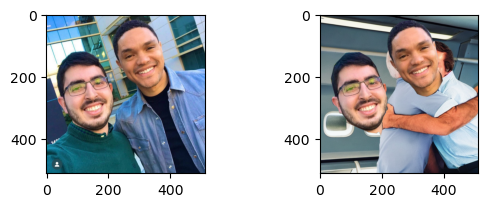

In [7]:
'''# import the cv2 library
import cv2

# The function cv2.imshow() is used to display an image in a window.

cv2.imshow('Source Image', init_image)
cv2.imshow('Fake Image', image_nat)



# waitKey() waits for a key press to close the window and 0 specifies indefinite loop
cv2.waitKey(0)
 
# cv2.destroyAllWindows() simply destroys all the windows we created.
cv2.destroyAllWindows()
'''

fig = plt.figure(figsize=(10, 7))
rows = 3
columns = 3

fig.add_subplot(rows, columns, 1) 
plt.imshow(init_image)
fig.add_subplot(rows, columns, 2) 
plt.imshow(image_nat)

'''fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

ax[0].imshow(init_image)
ax[1].imshow(image_nat)

ax[0].set_title('Source Image', fontsize=16)
ax[1].set_title('Fake Image.', fontsize=16)

for i in range(2):
    ax[i].grid(False)
    ax[i].axis('off')
    
fig.suptitle(f"Prompt: {prompt} | Seed: {SEED}", fontsize=20)
#fig.tight_layout()
plt.show()'''